# Hyperparameter Optimization In Ludwig



Demonstrates hyper-parameter tuning capabilities of Ludwig. The following steps occur in this notebook:
* Training data is prepared for use
* Programmatically create Ludwig config dictionary from the training data dataframe
* Setup parameter space for hyperparameter optimization
* Perform two hyperparameter runs
  * Parallel workers using random search strategy
  * Serial processing using random search strategy
  * Parallel workers using grid search strategy
* Demonstrate various Ludwig visualizations for hyperparameter optimization

## Import required libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import shutil
import datetime

import pandas as pd
import numpy as np

from ludwig.hyperopt.run import hyperopt
from ludwig.visualize import hyperopt_results_to_dataframe, hyperopt_hiplot_cli, hyperopt_report_cli

from sklearn.model_selection import train_test_split

## Retrieve data for training

In [2]:
train_df = pd.read_csv('./data/winequalityN.csv')
train_df.shape

(6497, 13)

## Standardize column names to replace spaces(" ") with underscore("_")

In [3]:
new_col = []
for i in range(len(train_df.columns)):
    new_col.append(train_df.columns[i].replace(' ', '_'))
    
train_df.columns = new_col

## Data Set Overview

In [4]:
train_df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

## Create training and test data sets

In [5]:
train_df['quality'].value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [6]:
# isolate the predictor variables only
predictor_vars = list(set(train_df.columns) - set(['quality']))

#extract categorical variables
categorical_vars = []
for p in predictor_vars:
    if train_df[p].dtype == 'object':
        categorical_vars.append(p)
        
print("categorical variables:", categorical_vars,'\n')

# get numerical variables
numerical_vars = list(set(predictor_vars) - set(categorical_vars))

print("numerical variables:", numerical_vars,"\n")

categorical variables: ['type'] 

numerical variables: ['sulphates', 'fixed_acidity', 'total_sulfur_dioxide', 'density', 'pH', 'residual_sugar', 'free_sulfur_dioxide', 'alcohol', 'citric_acid', 'volatile_acidity', 'chlorides'] 



In [7]:
train_df.describe().T

count        mean        std      min       25%  \
fixed_acidity         6487.0    7.216579   1.296750  3.80000   6.40000   
volatile_acidity      6489.0    0.339691   0.164649  0.08000   0.23000   
citric_acid           6494.0    0.318722   0.145265  0.00000   0.25000   
residual_sugar        6495.0    5.444326   4.758125  0.60000   1.80000   
chlorides             6495.0    0.056042   0.035036  0.00900   0.03800   
free_sulfur_dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total_sulfur_dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
pH                    6488.0    3.218395   0.160748  2.72000   3.11000   
sulphates             6493.0    0.531215   0.148814  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%        75%        max  
fixed_acidity           7.00000    7.70000   15.90000  
volatile_acidity        0.29000    0.40000    1.58000  
citric_acid             0.31000    0.39000    1.66000  
residual_sugar          3.00000    8.10000   65.80000  
chlorides               0.04700    0.06500    0.61100  
free_sulfur_dioxide    29.00000   41.00000  289.00000  
total_sulfur_dioxide  118.00000  156.00000  440.00000  
density                 0.99489    0.99699    1.03898  
pH                      3.21000    3.32000    4.01000  
sulphates               0.51000    0.60000    2.00000  
alcohol                10.30000   11.30000   14.90000  
quality                 6.00000    6.00000    9.00000

In [8]:
for p in categorical_vars:
    print("unique values for",p,"is",train_df[p].nunique())

unique values for type is 2


## Create config

In [9]:
# template for config
config = {'input_features':[], 'output_features': [], 'trainer':{}}

# setup input features for categorical variables
for p in categorical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'category', 'representation': 'sparse'}
    config['input_features'].append(a_feature)


# setup input features for numerical variables
for p in numerical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'number', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    config['input_features'].append(a_feature)

# set up output variable
config['output_features'].append({'name': 'quality', 'type':'category'})

# set up trainer
config['trainer'] = {'epochs': 20}

In [10]:
# View the config
print("config:")
config

config:


{'input_features': [{'name': 'type',
   'type': 'category',
   'representation': 'sparse'},
  {'name': 'sulphates',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'fixed_acidity',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'total_sulfur_dioxide',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'density',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'pH',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'residual_sugar',
   'type': 'number',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'free_sulfur_dioxide',
   't

## Define hyperparameter search space

In [11]:
SEED=13

hyperopt_configs = {
    "parameters": {
        "trainer.learning_rate": {
            "type": "float",
            "space": "loguniform",
            "lower": 0.0001,
            "upper": 0.01,
            "q": 3,
        },
        "trainer.batch_size": {
            "type": "int",
            "space": "qlograndint",
            "base" : 2,
            "lower": 32,
            "upper": 256,
            "q": 5,
        },
        "quality.fc_size": {
            "type": "int",
            'space': 'qrandint',
            "lower": 32,
            "upper": 256,
            "q": 5,
        },
        "quality.num_fc_layers": {
            'type': 'int',
            'space': 'qrandint',
            'lower': 1,
            'upper': 5,
            'q': 4,
        }
    },
    "goal": "minimize",
    'output_feature': "quality",
    'validation_metrics': 'loss'
}

# add hyperopt parameter space to the config
config['hyperopt'] = hyperopt_configs

## Train with optimal hyperparameters on the whole data set

In [12]:
# clean out old results
shutil.rmtree('./results_ray', ignore_errors=True)
shutil.rmtree('./results_random_serial', ignore_errors=True)
shutil.rmtree('./visualizations', ignore_errors=True)

#### Random Search with ray  executors

This executor will use a local run cluster with 3 samples (should take less than 30 seconds)

In [13]:
%%time
%%capture
print("starting:", datetime.datetime.now())
config['hyperopt']['executor'] = {'type': 'ray', 'time_budget_s': 1000}
config['hyperopt']['sampler'] = {'type': 'ray', 'num_samples': 3}
results_ray = hyperopt(
    config,
    dataset=train_df.sample(4000, random_state=42),  # limit number records for demonstration purposes
    output_directory='results_ray'  # location to place results
)

{   'executor': {'time_budget_s': 1000, 'type': 'ray'},
    'goal': 'minimize',
    'metric': 'loss',
    'output_feature': 'quality',
    'parameters': {   'quality.fc_size': {   'lower': 32,
                                             'q': 5,
                                             'space': 'qrandint',
                                             'type': 'int',
                                             'upper': 256},
                      'quality.num_fc_layers': {   'lower': 1,
                                                   'q': 4,
                                                   'space': 'qrandint',
                                                   'type': 'int',
                                                   'upper': 5},
                      'trainer.batch_size': {   'base': 2,
                                                'lower': 32,
                                                'q': 5,
                                                'space': 'qlograndin

#### Random Search with serial executor

Run the serialize executor with 2 samples (should take less then 3 minutes)

In [14]:
hyperopt_configs = {
    "parameters": {
        "trainer.learning_rate": {
            "type": "float",
            "low": 0.0001,
            "high": 0.01,
            "space": "log",
            "steps": 3,
        },
        "trainer.batch_size": {
            "type": "int",
            "low": 32,
            "high": 256,
            "space": "log",
            "steps": 5,
            "base" : 2
        },
        "quality.fc_size": {
            "type": "int",
            "low": 32,
            "high": 256,
            "steps": 5
        },
        "quality.num_fc_layers": {
            'type': 'int',
            'low': 1,
            'high': 5,
            'space': 'linear',
            'steps': 4
        }
    },
    "goal": "minimize",
    'output_feature': "quality",
    'validation_metrics': 'loss'
}

# add hyperopt parameter space to the config
config['hyperopt'] = hyperopt_configs

In [15]:
%%time
print("starting:", datetime.datetime.now())
config['hyperopt']['executor'] = {'type': 'serial'}
config['hyperopt']['sampler'] = {'type': 'random', 'num_samples': 2}
results_random_serial = hyperopt(
    config,
    dataset= train_df.sample(4000, random_state=42),  # limit number records for demonstration purposes
    output_directory='results_random_serial'
)

starting: 2022-04-09 15:09:04.768901
Note: steps_per_checkpoint (was 40) is now set to the number of steps per epoch: 40.

Note: steps_per_checkpoint (was 52) is now set to the number of steps per epoch: 52.

CPU times: user 17min 20s, sys: 48 s, total: 18min 8s
Wall time: 2min 42s


### Note:
`results_ray`, `results_random_serial` are `HyperoptResults` object with the ordered_trials, so will convert to dictionary to visualize.

In [20]:
def hyperopt_results_dict(results):
    return [{"metric_score": t.metric_score, "parameters": t.parameters} for t in results.ordered_trials]

## Convert hyperparameter optimization results to dataframe

#### Results For Ray executor

In [21]:
df1 = hyperopt_results_to_dataframe(
    hyperopt_results_dict(results_ray),
    hyperopt_configs['parameters'],
    hyperopt_configs['validation_metrics']
)
df1

loss  trainer.learning_rate  trainer.batch_size  quality.fc_size  \
0  1.291179               0.001393                 170               60   
1  1.300332               0.000203                  45              100   
2  1.956202               0.000527                  75               45   

   quality.num_fc_layers  
0                      4  
1                      4  
2                      0

#### Results for Random Search with serial executor

In [22]:
df2 = hyperopt_results_to_dataframe(
    hyperopt_results_dict(results_random_serial),
    hyperopt_configs['parameters'],
    hyperopt_configs['validation_metrics']
)
df2

loss  quality.fc_size  quality.num_fc_layers  trainer.batch_size  \
0  1.300466               75                      4                  55   
1  1.362126               45                      1                  72   

   trainer.learning_rate  
0               0.005918  
1               0.002479

## Example Hyperopt Visualizations

#### Report results of the a hyperparameter optimization run

In [31]:
%matplotlib inline

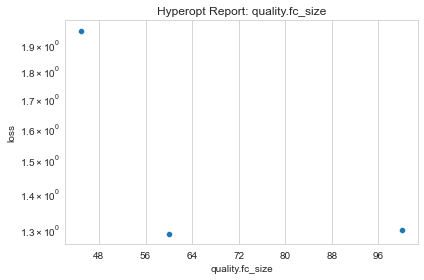

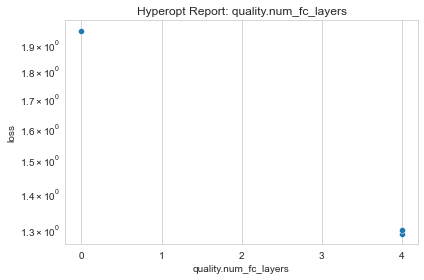

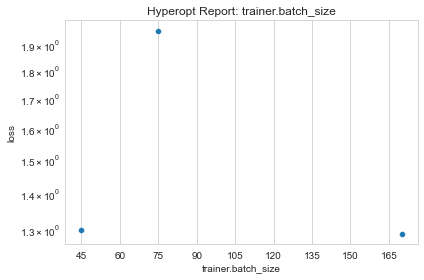

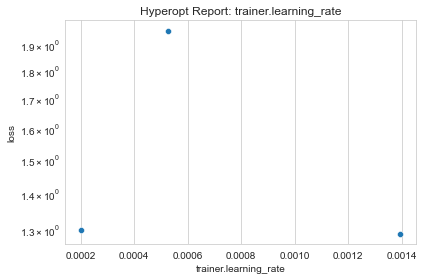

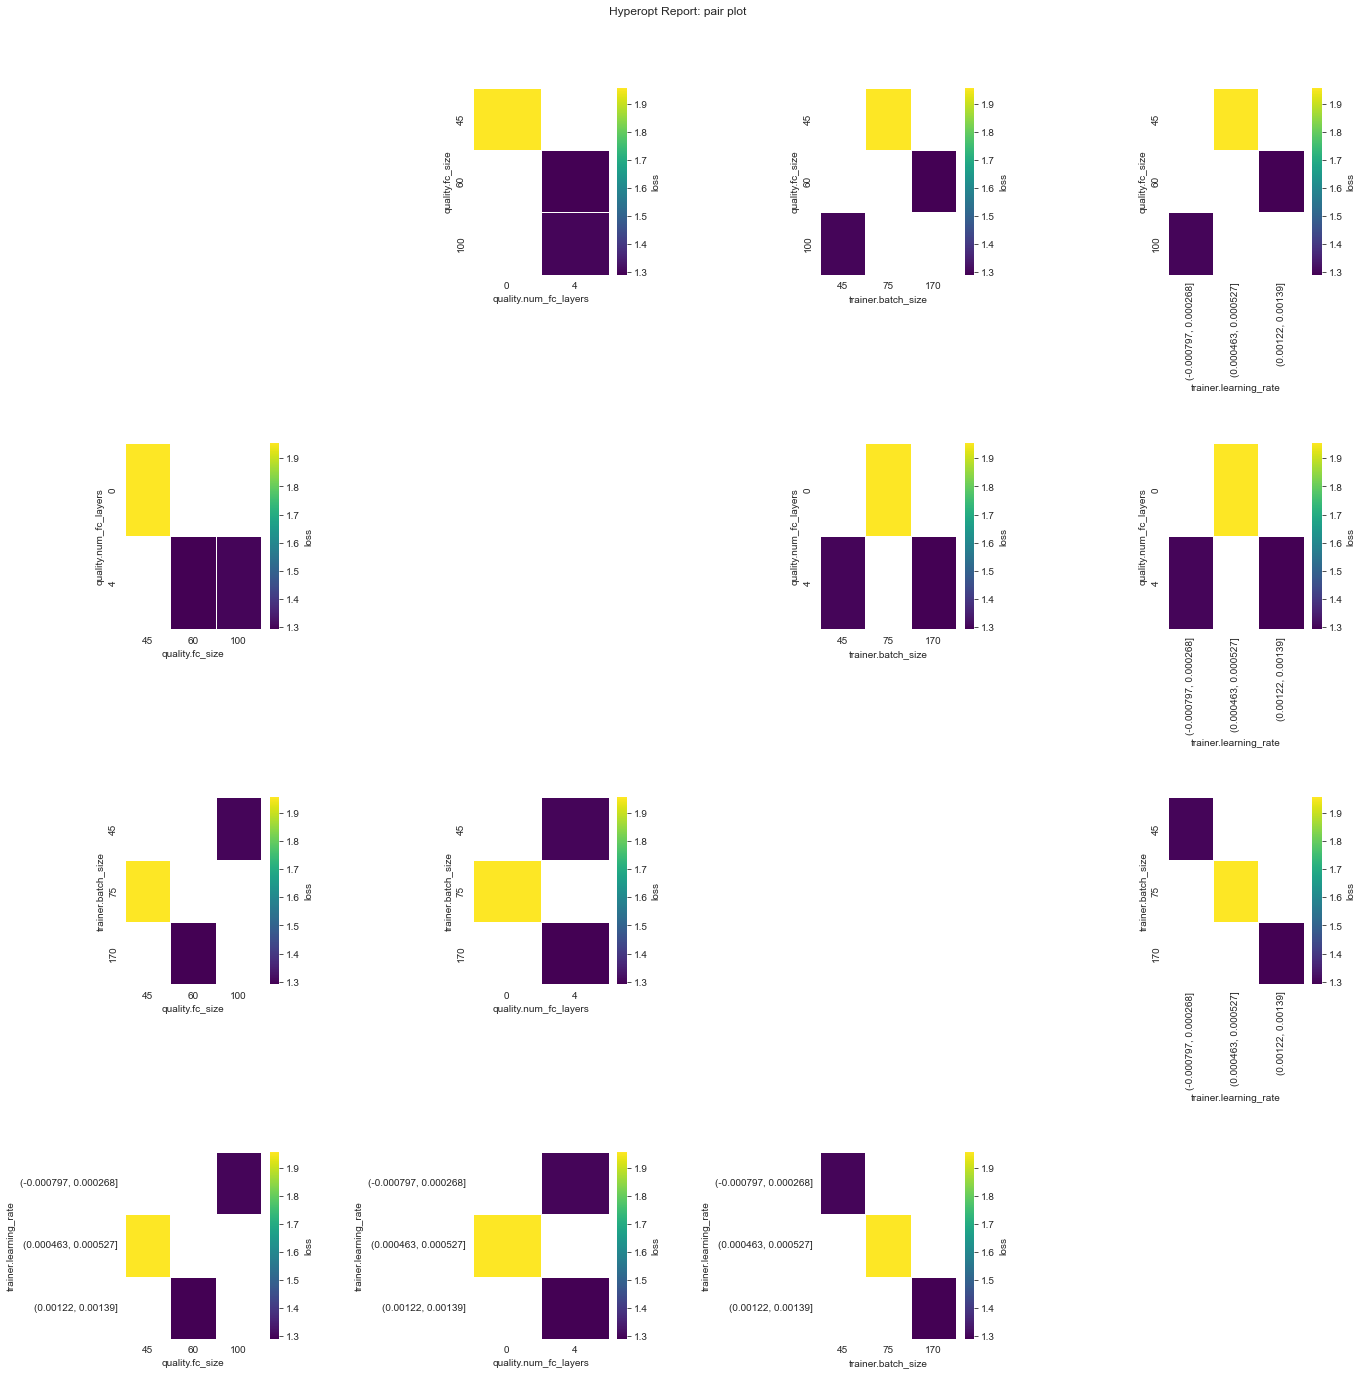

In [34]:
hyperopt_report_cli(
    'results_ray/hyperopt_statistics.json',
    output_directory='./visualizations'
)

#### Generate parallel coordinates plot on hyperparameter optimization

In [33]:
hyperopt_hiplot_cli(
    'results_ray/hyperopt_statistics.json',
    output_directory='./visualizations'
)

To view parallel coordinates plot, using your browser open html page in the `visualizations` directory, i.e, `visualizations/hyperopt_hiplot.html`.  The browser should display something similar to the image below.

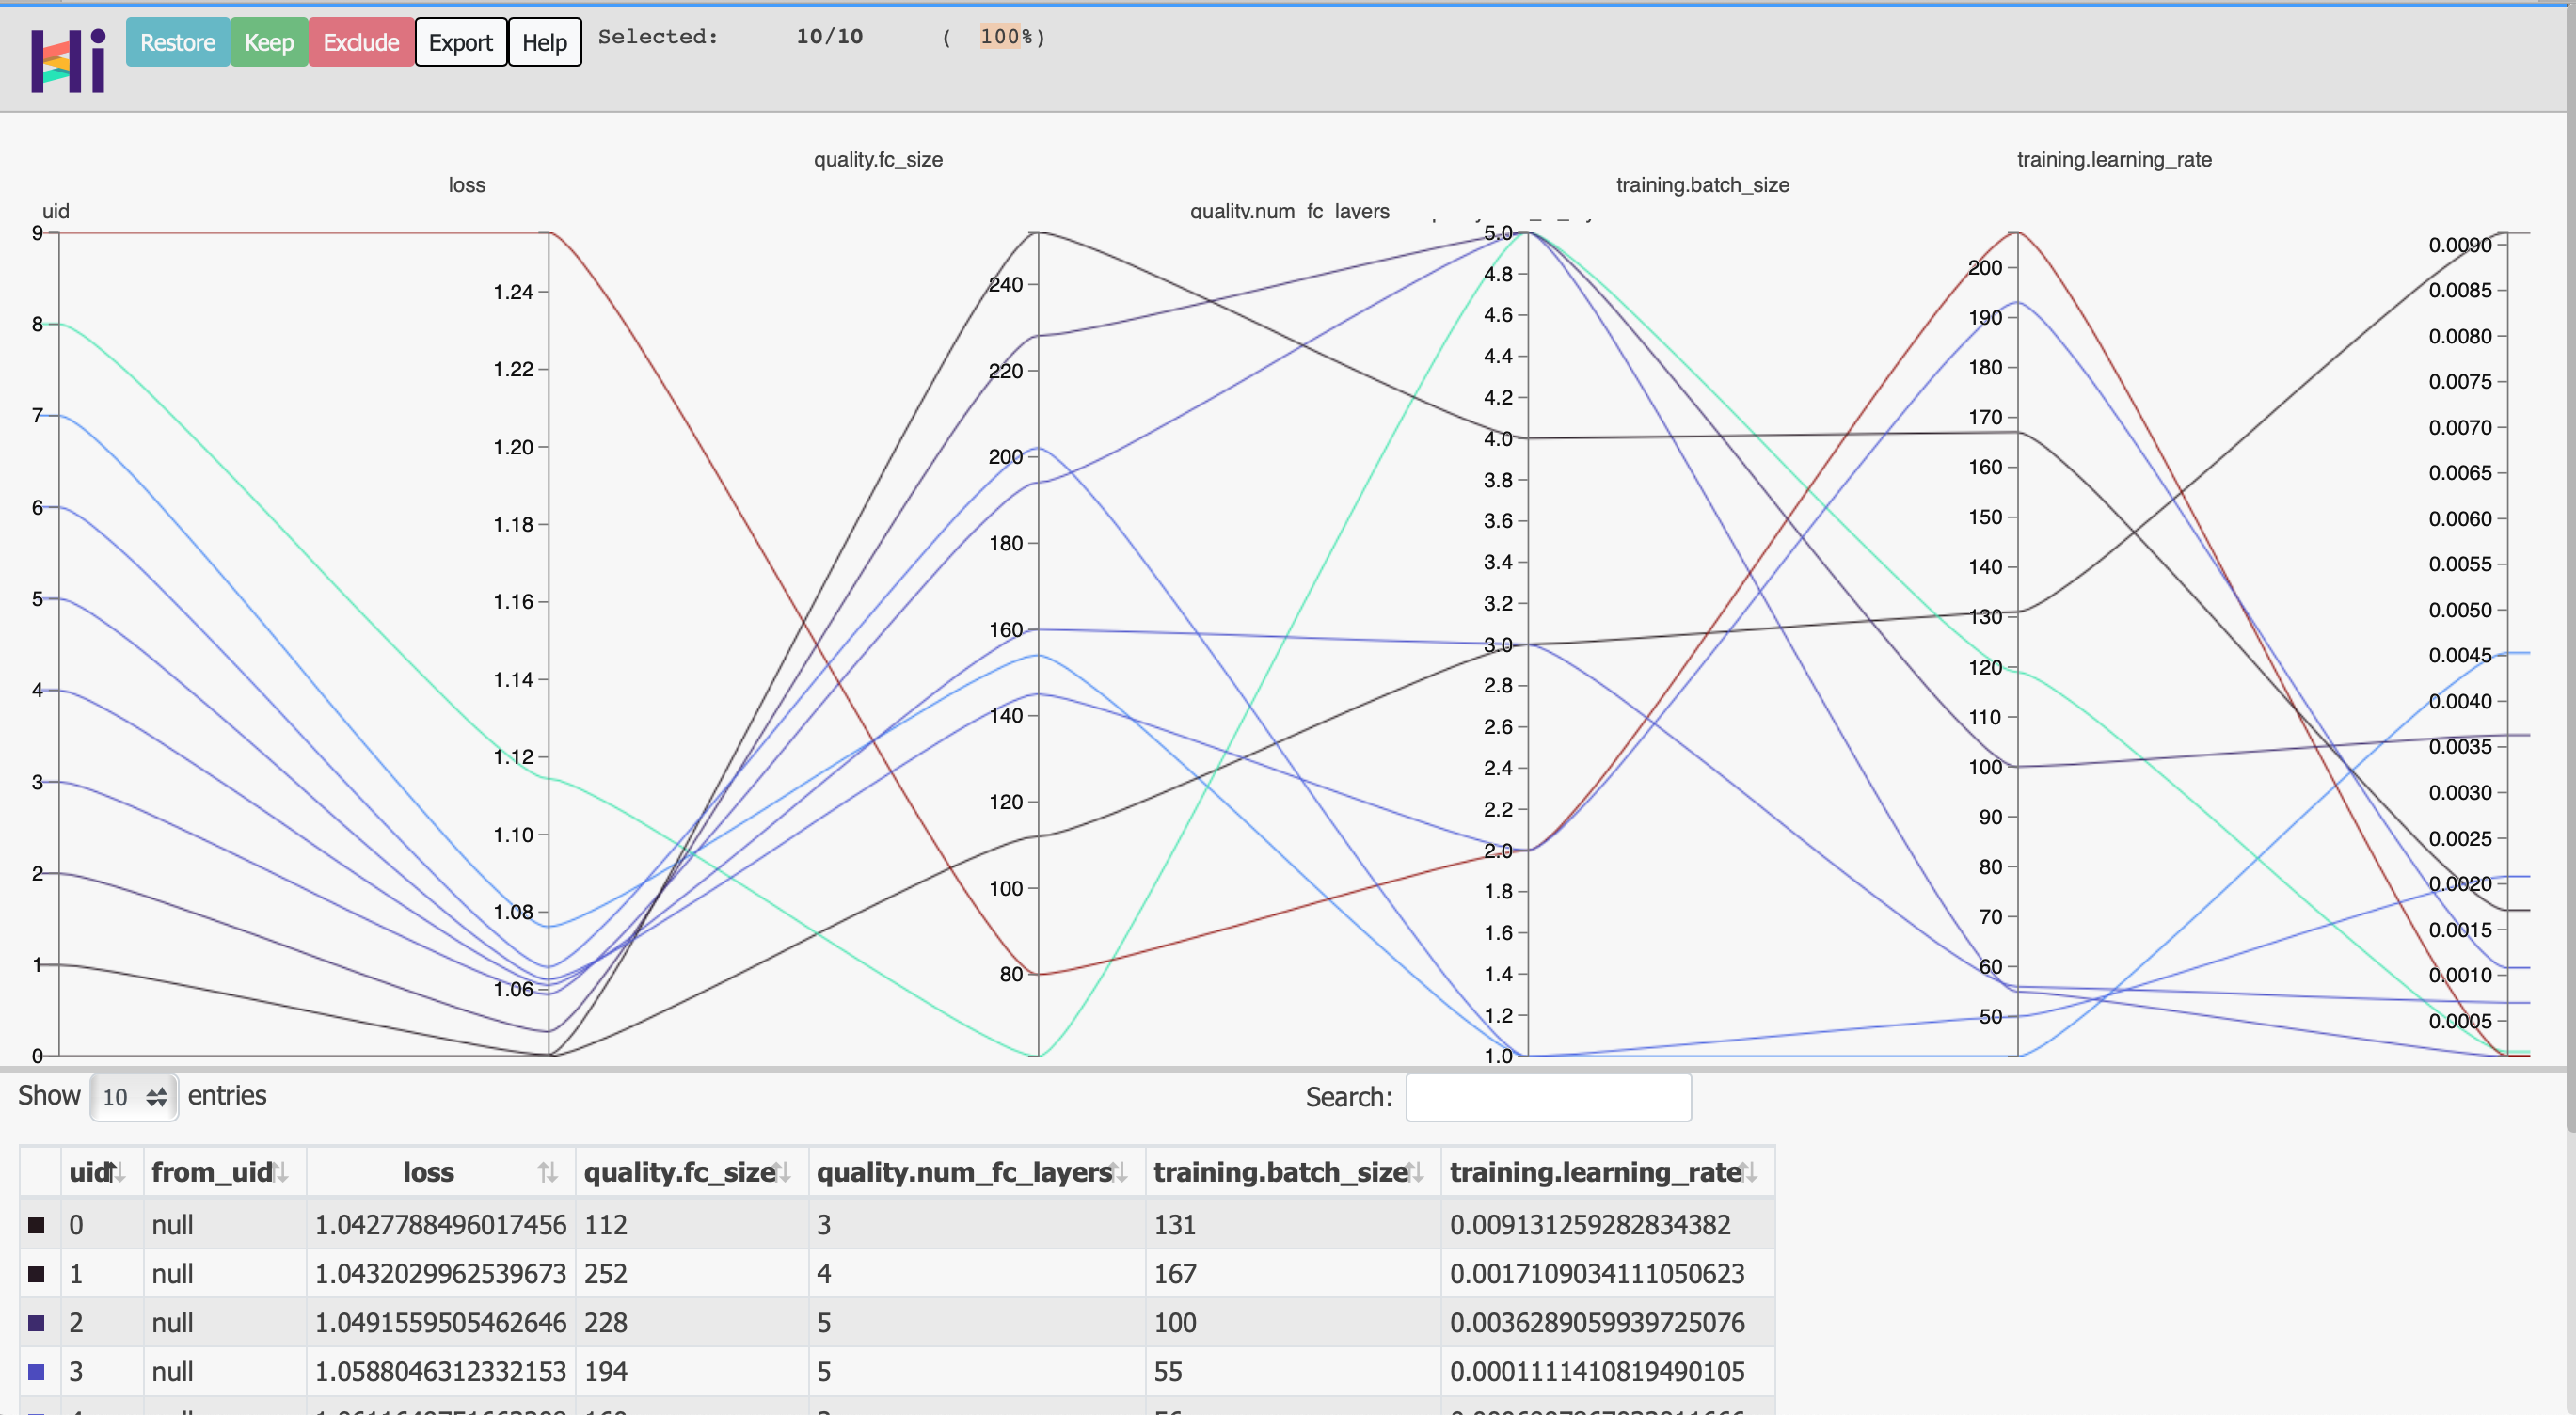

In [29]:
from IPython.display import Image
Image(filename='./images/parallel_coordinates_plot.png')